Defaulting to user installation because normal site-packages is not writeable
Número de muestras leídas: 1399
   Tiempo (s)   T1 (C)   T2 (C)   PWM_Heater1   PWM_Heater2
0        0.01    28.35    28.84             0             0
1        1.04    28.35    28.84             0             0
2        2.04    28.35    28.84             0             0
3        3.04    28.35    28.84             0             0
4        4.04    27.86    28.35             0             0


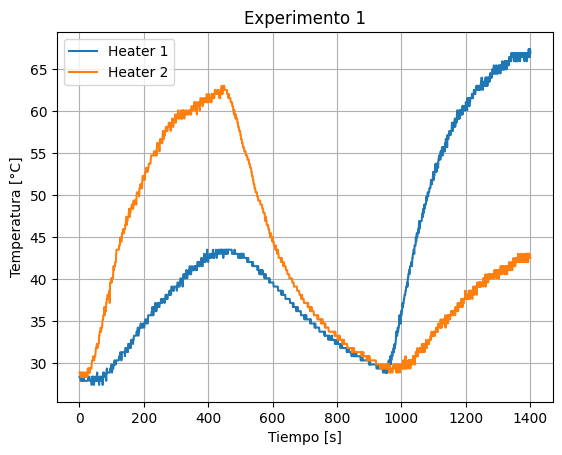

In [ ]:
! pip install pandas matplotlib scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import minimize

# 1. Leer el archivo de texto
#    Si tu archivo tiene encabezados en la primera fila y está separado por comas:
url = 'https://raw.githubusercontent.com/jbcgames/Lab_3_control/main/Exp1.txt'
df = pd.read_csv(url)

# 2. Extraer las columnas relevantes
#    Ajusta los nombres de columnas de acuerdo con tu archivo:
tiempo = df['Tiempo (s)'].values
T1 = df[' T1 (C)'].values
T2 = df[' T2 (C)'].values
pwm = df[' PWM_Heater1'].values

# (Opcional) Verificar rápidamente cuántas filas y columnas se leyeron
print("Número de muestras leídas:", len(df))
print(df.head())

plt.figure()
plt.plot(tiempo, T1, label='Heater 1')
plt.plot(tiempo, T2, label='Heater 2')
plt.xlabel('Tiempo [s]')
plt.ylabel('Temperatura [°C]')
plt.title('Experimento 1')
plt.grid(True)
plt.legend()
plt.show()


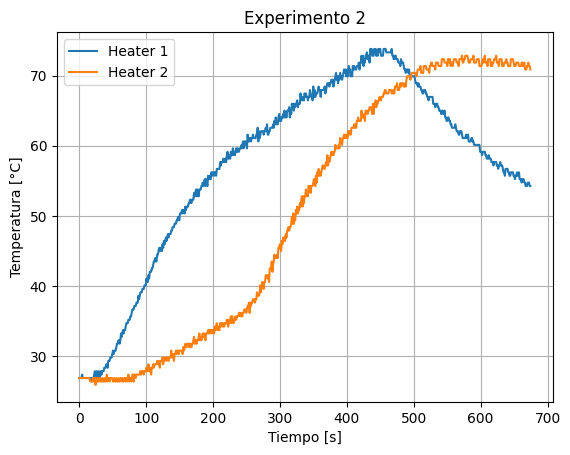

In [4]:
url = 'https://raw.githubusercontent.com/jbcgames/Lab_3_control/main/Exp2.txt'
df = pd.read_csv(url)

tiempo = df['Tiempo (s)'].values
T1 = df[' T1 (C)'].values
T2 = df[' T2 (C)'].values
pwm = df[' PWM_Heater1'].values

plt.figure()
plt.plot(tiempo, T1, label='Heater 1')
plt.plot(tiempo, T2, label='Heater 2')
plt.xlabel('Tiempo [s]')
plt.ylabel('Temperatura [°C]')
plt.title('Experimento 2')
plt.grid(True)
plt.legend()
plt.show()